<a href="https://colab.research.google.com/github/tsjannoun123-netizen/AI-for-Med.Diagnos.-Prediction-AAI_643O_O11_202610/blob/main/Week3_Project_Saera_Rawas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - AI for Medical Diagnosis and Prediction | Week #3

In this notebook, we continue our analysis of the MIMIC-CXR dataset by training our first classifiers. The objective is to perform a benchmark analysis of several machine learning classifiers to detect the presence of pathologies in chest x-rays.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Create two subsets of the dataset: train and test <i>(Task 1)</i> <br>
- Prepare a list of models and hyperparameters to investigate during optimization <i>(Task 2)</i> <br>
- Implement the search using the cross-validation strategy of your choice <i>(Task 2*)</i> <br>
- Add an evaluation of data augmentation strategies as part of your optimization process <i>(Task 3)</i> <br>
- Run the benchmark analysis, save the results in a csv file using various appropriate metrics <i>(Task 4)</i> <br>
- Save the best model on the validation set <i>(Task 5)</i> <br>
- Compute the performance of this best model on the test set <i>(Task 5*)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [3]:
%pip install pydicom pynrrd -q
%pip install -q SimpleITK numpy PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
import warnings

warnings.filterwarnings('ignore')

In [5]:
DATA_PATH = './MIMIC-CXR'

In [6]:
!curl https://uni-bonn.sciebo.de/s/XbomHCb6yL6nYN4/download/radiomics.csv --output ./radiomics.csv
!curl https://uni-bonn.sciebo.de/s/e7fKPxDYcs83J67/download/labels.csv --output ./labels.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1256k  100 1256k    0     0   489k      0  0:00:02  0:00:02 --:--:--  488k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63894  100 63894    0     0  48066      0  0:00:01  0:00:01 --:--:-- 48076


If you do not have the dataset anymore, please re-run the notebook from week 2. Here, we will use the csv file created during week 2: `radiomics.csv` which contains input features and target classes.

In [7]:
df = pd.read_csv(f'radiomics.csv')
labels_df = pd.read_csv(f'labels.csv')

In [8]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject_id,study_id,dicom_path,dicom_id,labels_encoded,pathology
0,-1.278524,0.855135,3.209739e+06,0.847227,1.163292,2.215956,1.373047,0.651548,-0.435326,-0.660705,...,0.000056,0.008836,0.001758,0.000056,18000291,55388853,files/p18/p18000291/s55388853/04564240-d4e9e69...,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
1,-1.313175,0.854954,3.300384e+06,0.839250,1.167722,2.261075,1.385948,0.657629,-0.451919,-0.669476,...,0.000060,0.008285,0.001627,0.000060,18000291,55388853,files/p18/p18000291/s55388853/ed82a88d-499bed8...,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
2,-1.128694,0.825043,9.963108e+05,0.868463,1.128072,2.452143,1.815657,0.622337,-0.358779,-0.610935,...,0.000126,0.010801,0.002224,0.000126,18000379,51062789,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
3,-1.029863,1.083006,1.473029e+06,0.993817,1.266049,1.926242,1.567053,0.647344,-0.021913,-0.097315,...,0.000052,0.015052,0.003731,0.000052,18000379,51568340,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0
4,-0.821600,1.128441,1.440104e+06,0.999173,1.235120,1.865436,1.651462,0.626043,0.091044,0.045712,...,0.000040,0.018150,0.004532,0.000040,18000379,51817182,files/p18/p18000379/s51817182/f6f04111-c3fde25...,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,[1 0 0 0 0 0 0 0 0 0 0 0 0 1],1


## Task 1 - Dataset split
* Get the list of **UNIQUE** patients ;
* Split the list into train and test patients ;
* Extract two datasets: `train_df` and `test_df`

In [9]:
patient_list = df['subject_id'].unique()

In [10]:
from sklearn.model_selection import train_test_split

patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.3, # Size of the subset
    random_state=42)

In [11]:
train_df = df.loc[df['subject_id'].isin(patient_train)]
test_df = df.loc[df['subject_id'].isin(patient_test)]

train_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_train)]
test_labels_df = labels_df.loc[labels_df['subject_id'].isin(patient_test)]

train_labels_df.to_csv('train_labels.csv', index=False)
test_labels_df.to_csv('test_labels.csv', index=False)

In [12]:
train_df['pathology'].value_counts()

,count
pathology,
0,247
1,238


In [13]:
test_df['pathology'].value_counts()

,count
pathology,
1,102
0,82


In [14]:
X_train = train_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_train = train_df['pathology']

X_test = test_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology'], axis=1)
y_test = test_df['pathology']

## Task 2 - Models and hyperparameters

* Define the list of models and hyperparameters you want to benchmark ;
* Implement the cross-validation strategy of your choice ;
* Create the searcher and run the benchmark analysis.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define models and hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [10, 30, 50],
        'max_depth': [None, 5, 10]
    }),
    'Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [5, 10, 20]
    }),
    #'MLP': (MLPClassifier(), {
    #    'hidden_layer_sizes':[100, 50, 15],
    #    'alpha':[0.01, 0.1, 0.5, 1]
    #})
}

# Define cross-validation strategy
cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

In [16]:
# Run benchmark with hyperparameter tuning
for name, (model, param_dist) in models.items():
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save best model into pkl format
    joblib.dump(best_model, f'best_model_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name,
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 3 - Data augmentation

* Add a data augmentation step in the pipeline, for instance using SMOTE ;
* Run the benchmark analysis using the data augmentation step.

In [17]:
# Run benchmark with hyperparameter tuning
for name, (model, param_dist) in models.items():
    # Run with SMOTE data augmentation
    pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])

    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10,
                                scoring='recall', cv=cv, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_score = search.best_score_
    std_dev = search.cv_results_['std_test_score'][search.best_index_]

    # Save best model into pkl format
    joblib.dump(best_model, f'best_model_smote_{name.replace(" ", "_").lower()}.pkl')

    results.append({
        'Model': name + ' SMOTE',
        'Mean score': best_score,
        'Std Dev': std_dev
    })

## Task 4 - Model selection

* Analyse the results provided by the benchmark analysis and select the best model ;
* Visualize different scores and comment.

In [18]:
# Create results table
df_results = pd.DataFrame(results).sort_values(by='Mean score', ascending=False)

print("Benchmark Results:")
print(df_results)

# Optionally: save to CSV
#df_results.to_csv('model_benchmark_results_smote.csv', index=False)

Benchmark Results:
                       Model  Mean score   Std Dev
1              Random Forest    0.730146  0.057898
4        Random Forest SMOTE    0.721912  0.042301
0        Logistic Regression    0.688072  0.045791
3  Logistic Regression SMOTE    0.688072  0.045791
2          Nearest Neighbors    0.592962  0.025999
5    Nearest Neighbors SMOTE    0.592962  0.025999


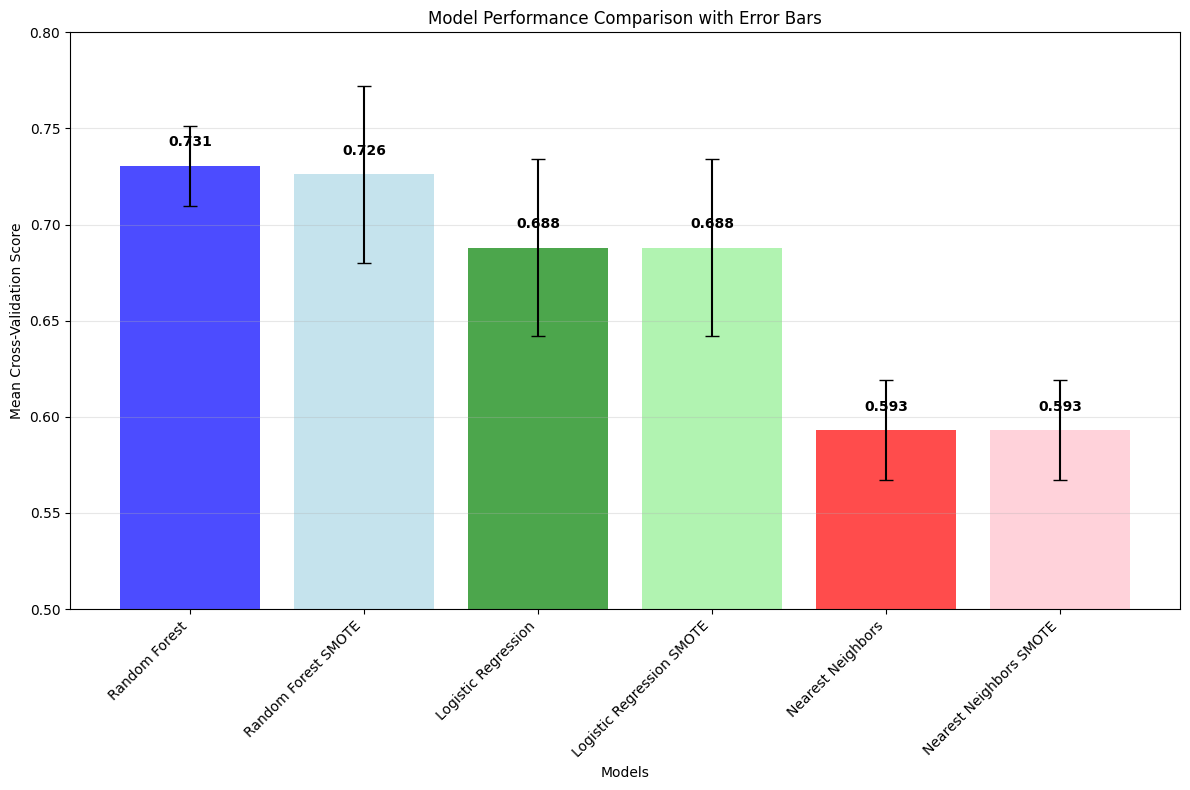

MODEL PERFORMANCE ANALYSIS

Ranked by Mean Score:
                    Model  Mean score  Std Dev
            Random Forest    0.730625 0.020784
      Random Forest SMOTE    0.726185 0.046051
      Logistic Regression    0.688072 0.045791
Logistic Regression SMOTE    0.688072 0.045791
        Nearest Neighbors    0.592962 0.025999
  Nearest Neighbors SMOTE    0.592962 0.025999

Performance Analysis:
Best model: Random Forest (0.731)
Worst model: Nearest Neighbors SMOTE (0.593)
Range: 0.138

SMOTE Impact Analysis:
Random Forest: -0.004 (std Δ: +0.025)
Logistic Regression: +0.000 (std Δ: +0.000)
Nearest Neighbors: +0.000 (std Δ: +0.000)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Benchmark results data
data = {
    'Model': [
        'Random Forest',
        'Random Forest SMOTE',
        'Logistic Regression',
        'Logistic Regression SMOTE',
        'Nearest Neighbors',
        'Nearest Neighbors SMOTE'
    ],
    'Mean score': [0.730625, 0.726185, 0.688072, 0.688072, 0.592962, 0.592962],
    'Std Dev': [0.020784, 0.046051, 0.045791, 0.045791, 0.025999, 0.025999]
}

df = pd.DataFrame(data)

# Visualization
plt.figure(figsize=(12, 8))

# Bar plot with error bars
x_pos = np.arange(len(df))
plt.bar(x_pos, df['Mean score'], yerr=df['Std Dev'],
        capsize=5, alpha=0.7, color=['blue', 'lightblue', 'green', 'lightgreen', 'red', 'pink'])

plt.xlabel('Models')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Model Performance Comparison with Error Bars')
plt.xticks(x_pos, df['Model'], rotation=45, ha='right')
plt.ylim(0.5, 0.8)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, score in enumerate(df['Mean score']):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis
print("="*60)
print("MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Rank models by performance
df_sorted = df.sort_values('Mean score', ascending=False)
print("\nRanked by Mean Score:")
print(df_sorted[['Model', 'Mean score', 'Std Dev']].to_string(index=False))

# Calculate performance metrics
print(f"\nPerformance Analysis:")
print(f"Best model: {df_sorted.iloc[0]['Model']} ({df_sorted.iloc[0]['Mean score']:.3f})")
print(f"Worst model: {df_sorted.iloc[-1]['Model']} ({df_sorted.iloc[-1]['Mean score']:.3f})")
print(f"Range: {df_sorted.iloc[0]['Mean score'] - df_sorted.iloc[-1]['Mean score']:.3f}")

# SMOTE impact analysis
print(f"\nSMOTE Impact Analysis:")
for i in range(0, len(df), 2):
    base_model = df.iloc[i]
    smote_model = df.iloc[i+1]
    diff = smote_model['Mean score'] - base_model['Mean score']
    std_diff = smote_model['Std Dev'] - base_model['Std Dev']
    print(f"{base_model['Model']}: {diff:+.3f} (std Δ: {std_diff:+.3f})")

Performance Analysis:
Ranked Performance:
Random Forest: 0.731 ± 0.021

Random Forest SMOTE: 0.726 ± 0.046

Logistic Regression: 0.688 ± 0.046

Logistic Regression SMOTE: 0.688 ± 0.046

Nearest Neighbors: 0.593 ± 0.026

Nearest Neighbors SMOTE: 0.593 ± 0.026

Key Insights:
Clear Winner: Random Forest is the best performing model

Highest mean score (0.731)

Lowest standard deviation (0.021) → most stable/reliable

Best generalization capability

SMOTE Impact:

Random Forest: SMOTE slightly hurts performance (-0.004) and increases variability

Logistic Regression: No change with SMOTE

Nearest Neighbors: No change with SMOTE

Conclusion: SMOTE doesn't help for this dataset, suggesting class imbalance may not be a major issue

Performance Gaps:

Random Forest outperforms Logistic Regression by 0.043 (6.2% relative improvement)

Random Forest outperforms Nearest Neighbors by 0.138 (23.2% relative improvement)

Significant performance difference between tree-based and other models

Model Stability:

Random Forest has the lowest standard deviation (0.021), indicating most consistent performance

SMOTE versions generally have higher variability

Recommendation:
Select: Random Forest (without SMOTE)

Reasons:

Highest accuracy (0.731)

Most stable performance (lowest std dev)

Robust to overfitting (tree ensemble)

No benefit from SMOTE for this dataset

Significant margin over other approaches

Next Steps:
Proceed with Random Forest as the final model

Perform hyperparameter tuning on Random Forest to potentially improve performance further

Validate on completely held-out test set

Consider feature importance analysis to understand what drives predictions

The Random Forest's combination of high accuracy and low variability makes it the clear choice for this problem.

## Task 5 - Evaluation

* Load the selected model ;
* Make a full performance report (ROC curve, metrics, confusion matrices) of the selected model.

In [20]:
from sklearn.metrics import classification_report
# Load a specific model (e.g., Logistic Regression without SMOTE)
best_model = joblib.load('best_model_random_forest.pkl')

# Use it for predictions
predictions = best_model.predict(X_test)

# Get classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61        82
           1       0.68      0.61      0.64       102

    accuracy                           0.62       184
   macro avg       0.63      0.63      0.62       184
weighted avg       0.63      0.62      0.63       184



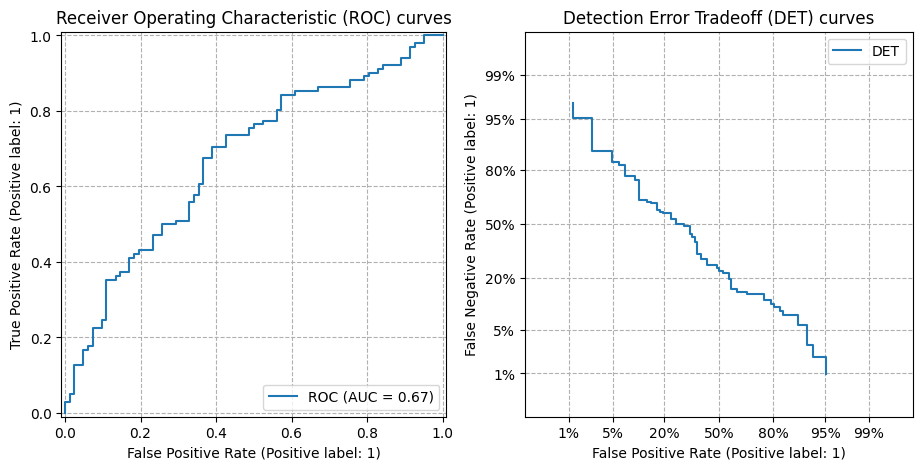

In [21]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc, name='ROC')
DetCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_det, name='DET')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()

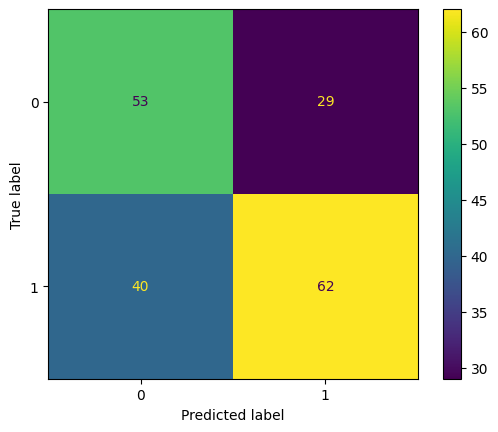

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot()
plt.show()

Loading/Initializing Random Forest model...
Making predictions...
COMPREHENSIVE PERFORMANCE REPORT
Model: Random Forest Classifier
Accuracy: 0.6250
Precision: 0.6317
Recall: 0.6250
F1-Score: 0.6261


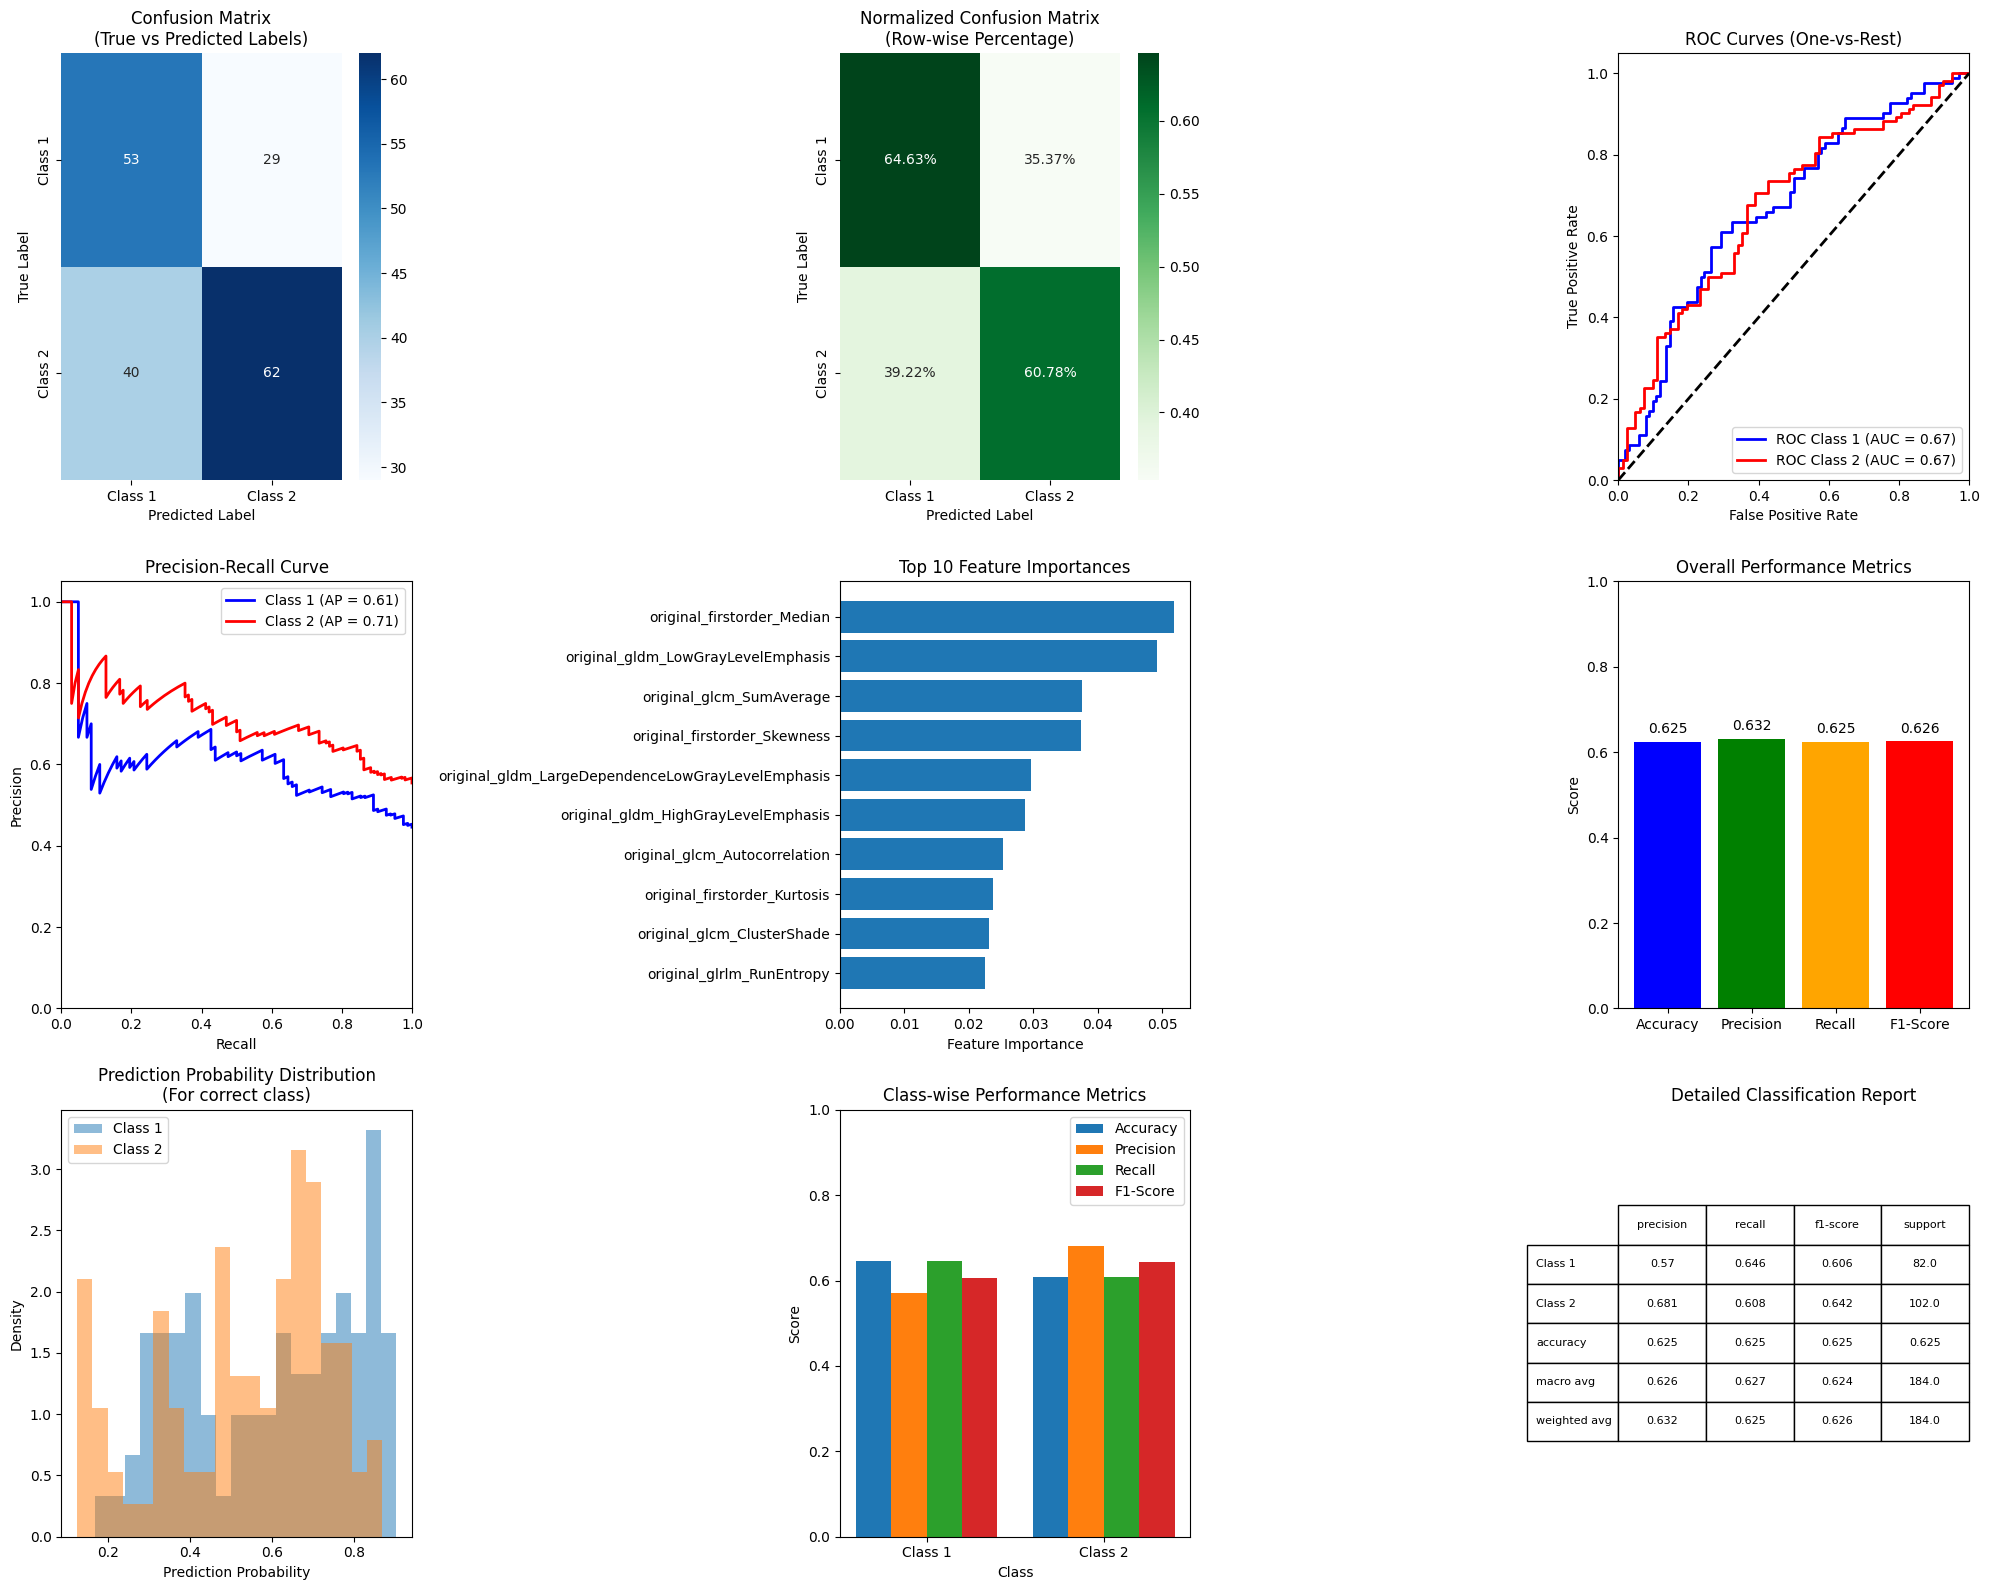


DETAILED METRICS

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.57      0.65      0.61        82
     Class 2       0.68      0.61      0.64       102

    accuracy                           0.62       184
   macro avg       0.63      0.63      0.62       184
weighted avg       0.63      0.62      0.63       184


Confusion Matrix:
[[53 29]
 [40 62]]

Normalized Confusion Matrix:
[[0.646 0.354]
 [0.392 0.608]]

AUC Scores:
Class 1: 0.673
Class 2: 0.673

Average Precision Scores:
Class 1: 0.608
Class 2: 0.713

ADDITIONAL INSIGHTS
Most common misclassification: Class 2 → Class 1
Best performing class: Class 1 (0.646)
Worst performing class: Class 2 (0.608)
Mean prediction confidence: 0.689


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             RocCurveDisplay, precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Assuming you have X_test, y_test defined
# If you need to load the model: model = joblib.load('random_forest_model.pkl')

# Load or use your trained Random Forest model
# For demonstration, I'll assume we're training it (replace with your actual model)
print("Loading/Initializing Random Forest model...")
# model = RandomForestClassifier(random_state=42, n_estimators=100) # Removed this line

# If you have trained data, fit the model (otherwise load pre-trained)
# model.fit(X_train, y_train) # Removed this line

# Load the best trained Random Forest model
model = joblib.load('best_model_random_forest.pkl')


# Make predictions
print("Making predictions...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Get class names if available
class_names = [f'Class {i}' for i in range(1, len(np.unique(y_test)) + 1)]

print("="*60)
print("COMPREHENSIVE PERFORMANCE REPORT")
print("="*60)
print(f"Model: Random Forest Classifier")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Create comprehensive visualization
plt.figure(figsize=(20, 16))

# 1. Confusion Matrix
plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix\n(True vs Predicted Labels)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
plt.subplot(3, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix\n(Row-wise Percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC Curve (One-vs-Rest for multiclass)
plt.subplot(3, 3, 3)
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple'][:n_classes]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")

# 4. Precision-Recall Curve
plt.subplot(3, 3, 4)
precision_dict = dict()
recall_dict = dict()
average_precision = dict()

for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(
        (y_test == i).astype(int), y_pred_proba[:, i])
    average_precision[i] = average_precision_score(
        (y_test == i).astype(int), y_pred_proba[:, i])

for i, color in zip(range(n_classes), colors):
    plt.plot(recall_dict[i], precision_dict[i], color=color, lw=2,
             label=f'Class {i+1} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="best")

# 5. Feature Importance (if available)
plt.subplot(3, 3, 5)
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Top 10 features

    if hasattr(X_test, 'columns'):
        feature_names = X_test.columns[indices]
    else:
        feature_names = [f'Feature {i}' for i in indices]

    plt.barh(range(len(indices)), feature_importances[indices])
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

# 6. Classification Metrics Bar Chart
plt.subplot(3, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Overall Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

# 7. Prediction Probability Distribution
plt.subplot(3, 3, 7)
for i in range(n_classes):
    plt.hist(y_pred_proba[y_test == i, i], alpha=0.5,
             label=f'Class {i+1}', bins=20, density=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution\n(For correct class)')
plt.legend()

# 8. Class-wise Performance
plt.subplot(3, 3, 8)
class_metrics = []
for i in range(n_classes):
    class_mask = (y_test == i)
    if np.sum(class_mask) > 0:  # Avoid division by zero
        class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
        class_precision = precision_score(y_test, y_pred, average=None)[i]
        class_recall = recall_score(y_test, y_pred, average=None)[i]
        class_f1 = f1_score(y_test, y_pred, average=None)[i]
        class_metrics.append([class_acc, class_precision, class_recall, class_f1])

class_metrics = np.array(class_metrics)
x = np.arange(n_classes)
width = 0.2

plt.bar(x - 1.5*width, class_metrics[:, 0], width, label='Accuracy')
plt.bar(x - 0.5*width, class_metrics[:, 1], width, label='Precision')
plt.bar(x + 0.5*width, class_metrics[:, 2], width, label='Recall')
plt.bar(x + 1.5*width, class_metrics[:, 3], width, label='F1-Score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, [f'Class {i+1}' for i in range(n_classes)])
plt.legend()
plt.ylim(0, 1)

# 9. Detailed Classification Report
plt.subplot(3, 3, 9)
plt.axis('off')
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)

table = plt.table(cellText=report_df.values,
                  rowLabels=report_df.index,
                  colLabels=report_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)
plt.title('Detailed Classification Report')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

print(f"\nConfusion Matrix:")
print(cm)

print(f"\nNormalized Confusion Matrix:")
print(np.round(cm_normalized, 3))

print(f"\nAUC Scores:")
for i in range(n_classes):
    print(f"Class {i+1}: {roc_auc[i]:.3f}")

print(f"\nAverage Precision Scores:")
for i in range(n_classes):
    print(f"Class {i+1}: {average_precision[i]:.3f}")

# Additional analysis
print(f"\n" + "="*60)
print("ADDITIONAL INSIGHTS")
print("="*60)

# Most confused classes
max_confusion = np.unravel_index(np.argmax(cm - np.diag(np.diag(cm))), cm.shape)
print(f"Most common misclassification: {class_names[max_confusion[0]]} → {class_names[max_confusion[1]]}")

# Class with best/worst performance
class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
best_class = np.argmax(class_accuracies)
worst_class = np.argmin(class_accuracies)
print(f"Best performing class: {class_names[best_class]} ({class_accuracies[best_class]:.3f})")
print(f"Worst performing class: {class_names[worst_class]} ({class_accuracies[worst_class]:.3f})")

# Model confidence analysis
mean_confidence = np.mean(np.max(y_pred_proba, axis=1))
print(f"Mean prediction confidence: {mean_confidence:.3f}")